# Introduction to Business Analytics
## Bike sharing trips in New York



Participants: 

- Elli Georgiou: s223408
- Maria Katarachia: s213633
- Stavroula Douva: s222652
- Michail-Achillefs Katarachias: s222653 
- Dimitris Voukatas: s230148



### Table of Content
- Section 1: **Introduction + Data Analysis \& Visualizations**
- Section 2: **Prediction models**
- Section 3: **Exploratory Component** 
- Section 4: **Conclusions**

### Section 1 : Introduction and Data Analysis and Visualizations

In this first section, we embark on the analysis of our dataframe, aiming to transform it into a higher-quality set that can provide meaningful insights for the subsequent phases of this project. The first crucial step involves preprocessing, which includes cleaning and organizing the dataset.

Cleaning is of paramount importance, encompassing tasks such as handling missing values, removing duplicates, and addressing outliers. These actions ensure that the data is reliable and free from errors, setting the foundation for robust analysis.

Following this approach, we filter the data based on relevant criteria. For instance, we seek data that adheres to logical parameters; for example, age should fall within a specific range, trip duration should follow a consistent format, and station locations must be within the boundaries of New York territory.

Once the data is cleaned and preprocessed, visualization emerges as a powerful tool for gaining initial insights. Visual representations, such as histograms, scatter plots, and correlation matrices, offer a holistic view, unveiling potential patterns, trends, or relationships throughout the dataset.

Firstly, we import all the libraries that will be used in this project.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from time import time
#import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
import math



import warnings
warnings.filterwarnings('ignore')

#### Data importing

We open the file and create a folder for our plots as well.

In [47]:
file_path = 'Trips_2018.csv'

if not os.path.exists('plots'):
    os.makedirs('plots')

with open(file_path, 'r') as f:
    df = pd.read_csv(f)

#### Data preprocessing

Let's take a look at how our dataframe looks like.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   tripduration             int64  
 2   starttime                object 
 3   stoptime                 object 
 4   start_station_id         float64
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_latitude     float64
 9   end_station_longitude    float64
 10  bikeid                   int64  
 11  usertype                 object 
 12  birth_year               int64  
 13  gender                   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.8+ GB


We remove the first column as it is just an intex and does not contribute to our analysis 

In [49]:
df = df.drop(df.columns[0], axis=1) 
df = df.sample(n=5000000, random_state=42)

Handling missing values

In [50]:
df.isnull().sum()

tripduration                 0
starttime                    0
stoptime                     0
start_station_id           740
start_station_latitude       0
start_station_longitude      0
end_station_id             740
end_station_latitude         0
end_station_longitude        0
bikeid                       0
usertype                     0
birth_year                   0
gender                       0
dtype: int64

In [51]:
df.duplicated().sum()

0

In [52]:
df = df[pd.to_numeric(df['start_station_id'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['end_station_id'], errors='coerce').notnull()]


We remove rows from the dataset that have null or non-numeric values in the'start_station_id' and 'end_station_id' columns. This is done by first converting  these columns to numeric types using the 'coerce' option in pd.to_numeric(). This converts any non-numeric values to NaN. Using that, we remove rows where these columns contain NaN values. This step guarantees that the dataset only contains rows with correct numeric station IDs.

The next step involves tackling the time-based details of our dataset. First, we converted 'starttime' and 'stoptime' into datetime data, which will make dealing with time series data much easier. Furthermore, we concentrated on the 'starttime' column to extract the date, hour, and day of the week, which it was quite informative as it helped us identify the bike usage trends, and recognize rush hours and how bike usage fluctuated throughout the week. Getting these information right from the start was an advantage as we had the opportunity to discover all sorts of interesting trends and really get to the core of the bike-sharing scene.

In [53]:
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['date'] = df['starttime'].dt.date
df['hour'] = df['starttime'].dt.hour
df['day_of_week'] = df['starttime'].dt.dayofweek

Moving forward, we improved the dataset by removing trips with negative or unusually lengthy durations, especially those lasting more than 3600 seconds (1 hour). In addition, to focus on more usual user behavior, we excluded trips outside the 99th percentile of trip durations. We filtered away records with birth years in the lowest 1st percentile to prevent outliers. We also made certain that only items with valid gender values of 0, 1, or 2 were included. Overall, these steps were critical in maintaining the authenticity of our dataset and creating the basis for accurate and meaningful analysis.

In [54]:
df = df[df['tripduration'] > 0]
df = df[df['tripduration'] <= 3600]
df = df[df['tripduration'] <= df['tripduration'].quantile(.99)]
df['tripduration'] = (df['stoptime'] - df['starttime']).dt.total_seconds()
df = df[df['birth_year'] >= df['birth_year'].quantile(.01)]
df = df[df['gender'].isin([0, 1, 2])]
df = df[df['gender'].isin([0, 1, 2])]


In [55]:
df.describe() #we use df.describe to investigate more how our data behave 

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,hour,day_of_week
count,4.855004e+06,4855004,4855004,4.855004e+06,4.855004e+06,4.855004e+06,4.855004e+06,4.855004e+06,4.855004e+06,4.855004e+06,4.855004e+06,4.855004e+06,4.855004e+06,4.855004e+06
mean,7.565509e+02,2018-07-16 02:52:56.437144576,2018-07-16 03:05:32.988044288,1.584816e+03,4.073721e+01,-7.398263e+01,1.575254e+03,4.073689e+01,-7.398285e+01,2.657809e+04,1.979404e+03,1.153785e+00,1.388676e+01,2.835726e+00
min,6.100100e+01,2018-01-01 00:02:43.918000,2018-01-01 00:06:11.383000,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.405570e+01,1.452900e+04,1.950000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.551340e+02,2018-05-08 18:00:23.987749888,2018-05-08 18:14:47.917500160,3.800000e+02,4.071755e+01,-7.399517e+01,3.790000e+02,4.071755e+01,-7.399548e+01,2.031600e+04,1.969000e+03,1.000000e+00,1.000000e+01,1.000000e+00
50%,5.942195e+02,2018-07-19 16:45:49.728999936,2018-07-19 16:59:31.376999936,5.050000e+02,4.073805e+01,-7.398565e+01,5.040000e+02,4.073756e+01,-7.398632e+01,2.828900e+04,1.982000e+03,1.000000e+00,1.500000e+01,3.000000e+00
75%,1.022619e+03,2018-09-27 17:14:26.088249856,2018-09-27 17:28:04.871500032,3.244000e+03,4.075757e+01,-7.397283e+01,3.244000e+03,4.075691e+01,-7.397344e+01,3.188500e+04,1.989000e+03,1.000000e+00,1.800000e+01,4.000000e+00
max,4.272033e+03,2018-12-31 23:59:51.085000,2019-01-01 00:40:50.880000,3.721000e+03,4.550636e+01,-7.356891e+01,3.721000e+03,4.550636e+01,-7.356891e+01,3.580600e+04,2.002000e+03,2.000000e+00,2.300000e+01,6.000000e+00
std,5.356774e+02,NaN,NaN,1.438804e+03,3.195009e-02,1.908098e-02,1.437947e+03,3.172200e-02,1.914614e-02,6.219231e+03,1.134306e+01,5.380453e-01,4.868325e+00,1.927056e+00


#### Visualizations

We visualize our data to gain useful insights.

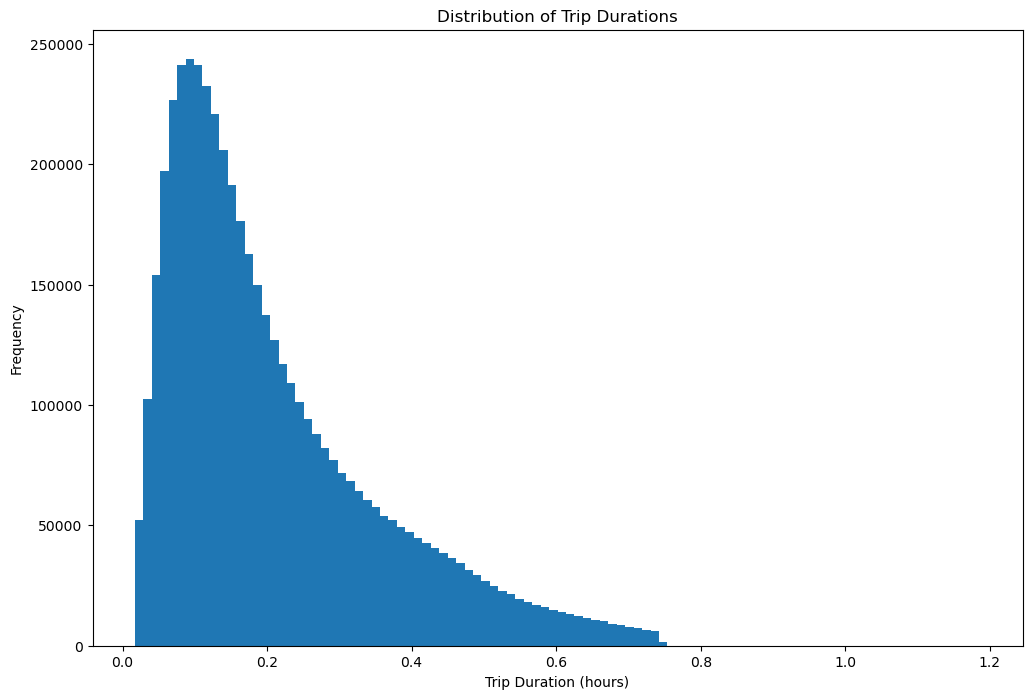

In [56]:
# Distribution of trip durations
plt.figure(figsize=(12, 8))
plt.hist(df['tripduration']/3600, bins=100)
plt.xlabel('Trip Duration (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Durations')
plt.savefig(os.path.join('plots', 'trip_duration_distribution.png'))
plt.show()


The histogram above depicts the distribution of trip durations, in hours. As the distribution is right skweed, we can tell that shorter trips are more frequent than longer ones. Most trips are shorter than 0.1 hours, and as trip length increases, the frequency decreases.

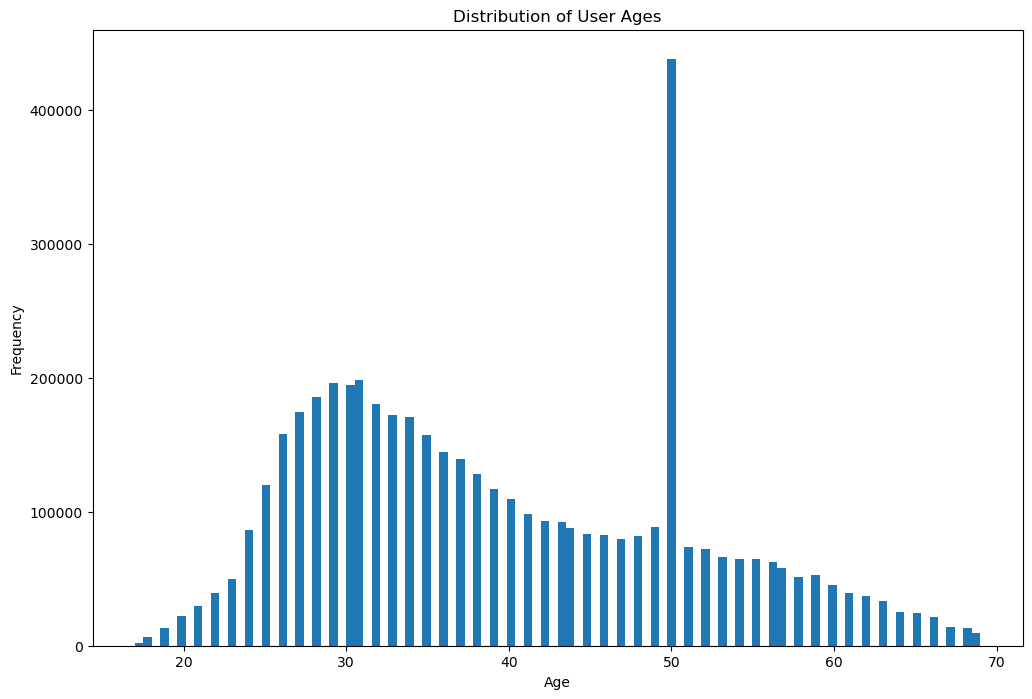

In [57]:
# Age distribution of the users.
plt.figure(figsize=(12, 8))
plt.hist(2019 - df['birth_year'], bins=100)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of User Ages')
plt.savefig(os.path.join('plots', 'age_distribution.png'))
plt.show()


The age distribution histogram clearly indicates the majority of users are between the ages of 20 and 40. Surprisingly, there is an a rise around the age of 50 which could be due to a number of factors, including a default entry value, a data error, or a large number of people in that age range. We notice a decrease of the distribution for the younger (20 years) and older (>60 years) age groups, reflecting that these groups use the service less. 

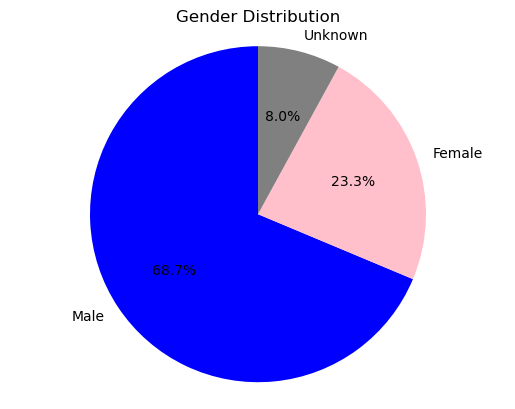

In [58]:
gender_counts = df['gender'].value_counts()
labels = ['Male', 'Female', 'Unknown']
colors = ['blue', 'pink', 'gray']

fig = plt.figure(facecolor='white')
plt.pie(gender_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal') 
plt.title('Gender Distribution')
plt.show()

The pie chart depicts the gender distribution among our users. Men constitute 68.2% of the population, while women represent about 23.2%. On the other hand, 8.6% of the user base is labeled 'Unknown.' This could imply that consumers prefer not to identify their gender, or that gender data was not collected. 

We finished the first phase of data preparation successfully, leaving us with a cleaned and improved dataset. We're now ready to move on to the next exciting phase: clustering our data by geographic location.

#### Clustering

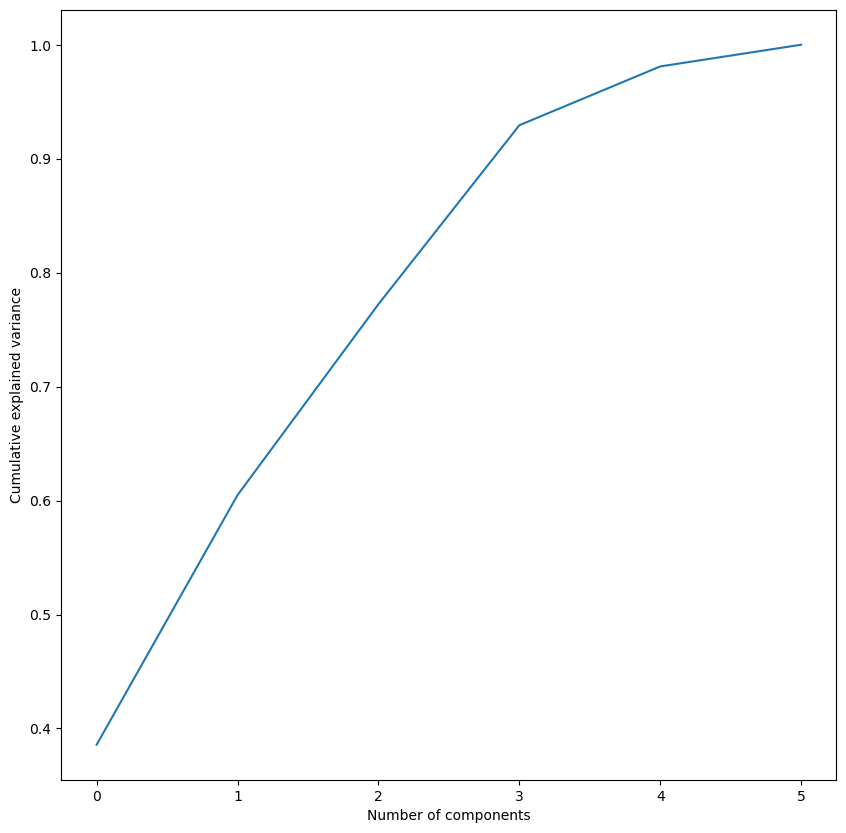


Principal Component 1 Loadings:
end_station_latitude       0.534724
start_station_latitude     0.532691
end_station_longitude      0.463838
start_station_longitude    0.463149
tripduration               0.023704
birth_year                -0.009755
Name: 0, dtype: float64

Principal Component 2 Loadings:
start_station_latitude     0.423059
end_station_latitude       0.417549
tripduration               0.204272
birth_year                -0.345242
start_station_longitude   -0.492779
end_station_longitude     -0.492872
Name: 1, dtype: float64

Principal Component 3 Loadings:
birth_year                 0.460564
end_station_latitude       0.180860
start_station_latitude     0.173851
end_station_longitude     -0.175021
start_station_longitude   -0.182169
tripduration              -0.813098
Name: 2, dtype: float64

Principal Component 4 Loadings:
birth_year                 0.817672
tripduration               0.544487
start_station_latitude     0.088736
end_station_latitude       0.079130
star

In [59]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration']])
scaled_df = pd.DataFrame(scaled_df, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])

pca = PCA(n_components=6)
pca.fit(scaled_df)
pca_df = pca.transform(scaled_df)
pca_df = pd.DataFrame(pca.components_, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])


plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.savefig(os.path.join('plots', 'pca_cumulative_explained_variance.png'))
plt.show()

corr_matrix = scaled_df.corr()
corr_matrix['tripduration'].sort_values(ascending=False)

for i in range(len(pca_df)):
    print(f"\nPrincipal Component {i + 1} Loadings:")
    print(pca_df.iloc[i].sort_values(ascending=False))


Our Principal Component Analysis results show that geographic coordinates, particularly start and end station latitudes and longitudes, play an important role in the variance of our data. These factors have a large influence on the first two components, which  shows that location is an important element in our dataset. Interestingly, the third component puts less emphasis on trip duration, showing that the duration of bike usage might be less influenced by local factors. The cumulative explained variance plot, helped us also decide how many components to keep. It shows that the first few components account for the vast majority of the variance. 

#### Elbow method

In order to identify the optimal number of clusters for the clustering algorithm we chose the elbow method.

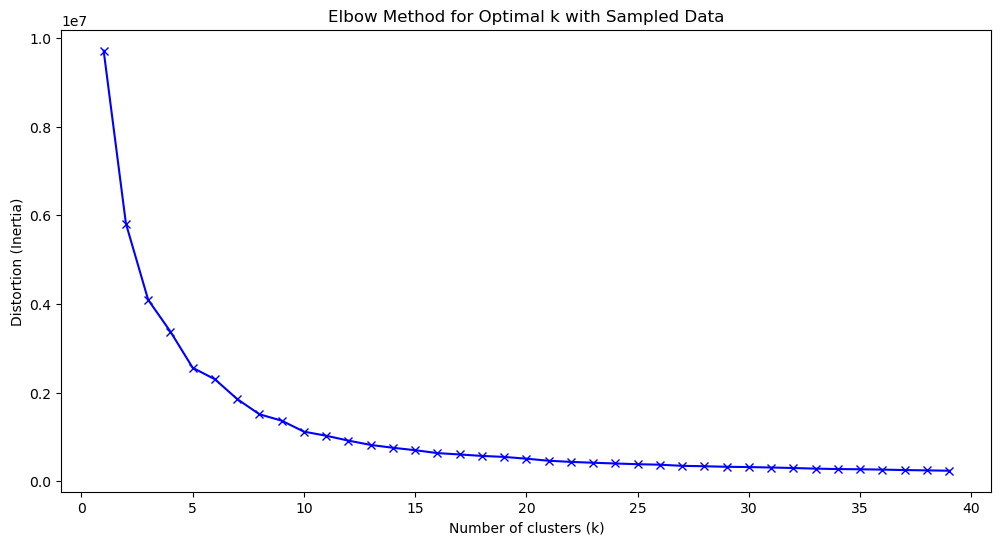

In [60]:
coordinates_sample = df[['start_station_latitude', 'start_station_longitude']]
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_sample)

distortions = []
K = range(1, 40)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(coordinates_standardized)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k with Sampled Data')
plt.show()


We used the Elbow Method to determine the optimal number of clusters for our K-means clustering. With this method we plot the number of clusters against the intertia which measures how compact the clusters are. As the number of clusters increases, so does the inertia, with each point expressing the total distance of data points from their centroids. The optimal number of clusters appears to be around 5 , meaning that adding more clusters beyond this point does not greatly improve the fineness of our grouping. Therefore we chose to continue with the minimum clusters that we are allowed which are 20.

Preprocessed our location data to handle the outliers

In [61]:
coordinates_start = df[['start_station_latitude', 'start_station_longitude']]
coordinates_end = df[['end_station_latitude', 'end_station_longitude']]

scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_start)

kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(coordinates_standardized)
df['cluster'] = kmeans.predict(coordinates_standardized)

kmeans = KMeans(n_clusters=20, init='k-means++', random_state=42).fit(coordinates_start)
centers = kmeans.cluster_centers_

df['cluster'] = kmeans.predict(coordinates_start)

We effectively categorized our dataset into 20 distinct clusters by applying the K-means algorithm to our standardized start station coordinates. Each data point was assigned to a single cluster using this method. The clustering helps us identify useful information on station popularity and user behavior trends. 

Plot the clusters on a map.

In [62]:
def plot_stations_map(stations):
    #First before plotting we have to deal with the outliers 
    #The latitude of New York City is approximately between 40.4774 and 45.01585, and the longitude is approximately between -79.76259 and -71.18507.

    lon_min = -79.76259
    lat_min = 40.4774
    lon_max = -71.18507
    lat_max = 45.01585

    # Store the stations that are within the boundaries
    stations = stations[
        (stations['start_station_latitude'] > lat_min) &
        (stations['start_station_latitude'] < lat_max) &
        (stations['start_station_longitude'] > lon_min) &
        (stations['start_station_longitude'] < lon_max)
    ]
    
    title = 'Citi Bike Stations in New York City'
    fig = px.scatter_mapbox(
        stations,
        lat='start_station_latitude',
        lon='start_station_longitude',
        color='cluster',
        mapbox_style='carto-positron',
        zoom=9,
        width=1000,
        height=600
    )
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,  
            xanchor='center',  
            font=dict(size=20)
        )
    )
    fig.show()


Remove the locations that are more than 3 standard deviations from the center of the clusters.

In [63]:
# Calculate the distance between each point and its cluster center
distance = kmeans.transform(coordinates_start)
min_distance = np.min(distance, axis=1) #we get the minimum distance for each point and its cluster index
min_distance_cluster = np.argmin(distance, axis=1)
threshold = 2*np.std(distance,axis=1)
within_threshold = np.argwhere(min_distance < threshold).flatten()

df = df.iloc[within_threshold]#we remove the points that are outside the threshold distance of a cluster center

# Plot the stations with an underlying map of New York City.
# plot_stations_map(df)

After clustering the stations, we concentrated on making these groups more relevant by removing outliers, especially, stations that were more than two standard deviations out from their cluster centers. The final result is a map, with each station color-coded to its respective cluster. This map not only depicts the distribution of bike stations around the city, but it also highlights locations with high station density. 

#### Cluster with the largest demand

After identifying clusters based on departure stations, the next step is to determine which cluster exhibits the largest demand in terms of the number of pickups.

In [64]:
# We work with the cluster with the largest demand.
larg_cluster = df['cluster'].value_counts().index[0]
df_cluster = df[df['cluster'] == larg_cluster]

# We want to create two timeseries that will describe for hourly intervals the pick up and the dropoffs counts for the one cluster with the largest demand.
df_cluster

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,date,hour,day_of_week,cluster
15586679,1396.470,2018-11-07 08:00:02.037,2018-11-07 08:23:18.507,445.0,40.727408,-73.981420,477.0,40.756405,-73.990026,26403,Subscriber,1978,1,2018-11-07,8,2,0
13787613,413.431,2018-10-06 14:26:03.075,2018-10-06 14:32:56.506,174.0,40.738177,-73.977387,491.0,40.740964,-73.986022,30781,Subscriber,1989,1,2018-10-06,14,5,0
6605124,546.180,2018-06-15 14:43:39.614,2018-06-15 14:52:45.794,497.0,40.737050,-73.990093,301.0,40.722174,-73.983688,27254,Subscriber,1989,2,2018-06-15,14,4,0
10882812,2105.335,2018-08-22 16:36:20.666,2018-08-22 17:11:26.001,497.0,40.737050,-73.990093,3132.0,40.763505,-73.971092,31988,Subscriber,1960,1,2018-08-22,16,2,0
9079209,345.960,2018-07-05 08:57:45.723,2018-07-05 09:03:31.683,3263.0,40.729515,-73.990753,3467.0,40.724947,-74.001659,18799,Subscriber,1997,2,2018-07-05,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11548181,554.676,2018-09-01 16:15:59.272,2018-09-01 16:25:13.948,293.0,40.730207,-73.991026,358.0,40.732916,-74.007114,34188,Subscriber,1987,1,2018-09-01,16,5,0
1227497,318.381,2018-02-05 08:04:38.533,2018-02-05 08:09:56.914,537.0,40.740259,-73.984092,496.0,40.737262,-73.992390,32801,Subscriber,1952,1,2018-02-05,8,0,0
16661423,797.854,2018-12-04 12:32:55.147,2018-12-04 12:46:13.001,445.0,40.727408,-73.981420,303.0,40.723627,-73.999496,27926,Subscriber,1993,1,2018-12-04,12,1,0
14984826,161.153,2018-10-26 11:08:40.489,2018-10-26 11:11:21.642,545.0,40.736502,-73.978095,504.0,40.732219,-73.981656,34357,Subscriber,1989,1,2018-10-26,11,4,0


### Section 2: Prediction models

In [65]:
# Data preproccesing we keep only the ccolumns we need
columns_to_remove = ['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_latitude','end_station_longitude','bikeid','day_of_week','usertype','birth_year','gender']
df_cluster = df_cluster.drop(columns=columns_to_remove, axis=1)


In [66]:
# We observe how the new dataframe looks like 
df_cluster

,tripduration,starttime,stoptime,date,hour,cluster
15586679,1396.470,2018-11-07 08:00:02.037,2018-11-07 08:23:18.507,2018-11-07,8,0
13787613,413.431,2018-10-06 14:26:03.075,2018-10-06 14:32:56.506,2018-10-06,14,0
6605124,546.180,2018-06-15 14:43:39.614,2018-06-15 14:52:45.794,2018-06-15,14,0
10882812,2105.335,2018-08-22 16:36:20.666,2018-08-22 17:11:26.001,2018-08-22,16,0
9079209,345.960,2018-07-05 08:57:45.723,2018-07-05 09:03:31.683,2018-07-05,8,0
...,...,...,...,...,...,...
11548181,554.676,2018-09-01 16:15:59.272,2018-09-01 16:25:13.948,2018-09-01,16,0
1227497,318.381,2018-02-05 08:04:38.533,2018-02-05 08:09:56.914,2018-02-05,8,0
16661423,797.854,2018-12-04 12:32:55.147,2018-12-04 12:46:13.001,2018-12-04,12,0
14984826,161.153,2018-10-26 11:08:40.489,2018-10-26 11:11:21.642,2018-10-26,11,0


#### Pick up Dataframe

Initially we create the pick ups dataframe. We have divided our data into hourly intervals in order to prepare it for analysis and make sure it was best organized for our assessment procedure.

In [67]:
pickups = df_cluster.copy()
pickups.set_index('starttime', inplace=True)

# We work on hourly intervals for pick ups 
hourly_pickups = pickups.resample('H').count() 

# We keep only the columns that contain valuable information
columns_to_drop = ['tripduration', 'stoptime', 'date', 'cluster']
hourly_pickups = hourly_pickups.rename(columns={'hour': 'pickup_counts'})
hourly_pickups = hourly_pickups.drop(columns=columns_to_drop)
hourly_pickups

,pickup_counts
starttime,
2018-01-01 00:00:00,3
2018-01-01 01:00:00,5
2018-01-01 02:00:00,1
2018-01-01 03:00:00,1
2018-01-01 04:00:00,1
...,...
2018-12-31 18:00:00,13
2018-12-31 19:00:00,3
2018-12-31 20:00:00,5


In [23]:
# # We plot the pick ups on hourly basis 
# fig = px.line(hourly_pickups, x=hourly_pickups.index, y='pickup_counts', title='Hourly Pickup Counts Time Series')
# fig.update_layout(
#     xaxis_title='Datetime',
#     yaxis_title='Pickup Counts',
#     hovermode='x',  
#     template='plotly_dark'  
# )

# fig.show()


As we expected from spring till late Autumn where the weather conditions are ideally to rent the bike and especially during the summer period the demand of bike sharing is at its peak.

#### Drop off dataframe


Similarly, we create the accordinely dataframe for drop offs. 

In [68]:
# Extracting the hour component from the 'stoptime' column and creating a new 'dropoff_hour' column
df_cluster['dropoff_hour'] = df_cluster['stoptime'].dt.hour
df_cluster = df_cluster.rename(columns={'hour': 'pickup_hour'})
dropoff = df_cluster.copy()

# We keep the important feature for our model.
columns_to_drop = ['tripduration', 'starttime', 'date', 'cluster', 'pickup_hour']
dropoff = dropoff.drop(columns=columns_to_drop)

dropoff.set_index('stoptime', inplace=True)
hourly_dropoff = dropoff.resample('H').count()
hourly_dropoff = hourly_dropoff.rename(columns={'dropoff_hour': 'dropoff_counts'})
hourly_dropoff

,dropoff_counts
stoptime,
2018-01-01 00:00:00,3
2018-01-01 01:00:00,5
2018-01-01 02:00:00,1
2018-01-01 03:00:00,0
2018-01-01 04:00:00,2
...,...
2018-12-31 18:00:00,12
2018-12-31 19:00:00,5
2018-12-31 20:00:00,6


In [25]:
# fig = px.line(hourly_dropoff, x=hourly_dropoff.index, y='dropoff_counts', title='Hourly Dropoff Counts Time Series')

# fig.update_layout(
#     xaxis_title='Datetime',
#     yaxis_title='Dropoff Counts',
#     hovermode='x',  
#     template='plotly_dark'  
# )
# fig.show()

We applied time aggregation so we can forecast the demand on an hourly basis. By removing the irrelevant columns we made sure that our models focus on the most impactful features, which are the times of pickups and dropoffs.

#### Linear Regression Model Fitting

Understanding the inherent time-series structure of our data, we included lagged features, specifically a 24-hour lag, thinking that the previous day's demand patterns would be an indicator of the trends the next day. 

To handle the challenge of predicting bike-sharing demand, we used hourly time aggregation, enabling us to accurately forecast the number of pickups and dropoffs for each hour of the next day. Our models emphasize on the important elements of pickup and dropoff timings, which impact demand patterns. We established a 24-hour lag in our time-series data to support our theory that demand patterns from the previous day provide useful insights into the next day's trends. Importantly, we followed the task's parameters by training our models on data from January to October and testing them on data from November and December. 

In [69]:
# we create the lagged features
def create_lagged_features(df, lag_hours_list):
    for lag_hours in lag_hours_list:
        lag_name = f'lag_{lag_hours}hr'
        df[lag_name] = df.iloc[:, 0].shift(lag_hours)
    return df.dropna()


lag_hours_list = [1, 24, 168]  # 1 hour, 1 day, 1 week
#lag_hours_list = [24]  # only for the day before

hourly_pickups = create_lagged_features(hourly_pickups, lag_hours_list)
hourly_dropoff = create_lagged_features(hourly_dropoff, lag_hours_list)

def fit_and_evaluate(df, target_col, split_date):
    split_date = pd.to_datetime(split_date)
    train = df[df.index < split_date]
    test = df[df.index >= split_date]

    X_train = train.drop(target_col, axis=1)
    y_train = train[target_col]
    X_test = test.drop(target_col, axis=1)
    y_test = test[target_col]

    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    r2 = r2_score(y_test, predictions)
    return r2


split_date = '2018-11-01'  
r2_pickups = fit_and_evaluate(hourly_pickups, 'pickup_counts', split_date)
r2_dropoff = fit_and_evaluate(hourly_dropoff, 'dropoff_counts', split_date)

print(f"R² Score for Pickups: {r2_pickups}")
print(f"R² Score for Dropoffs:{r2_dropoff}")

R² Score for Pickups: 0.7758606185380821
R² Score for Dropoffs:0.782593450939748


- **Linear Regression for Pickups:** For predicting pickups, the Linear Regression model had an R2 score of 0.7843, which indicates a strong linear relationship between the features and the pickup counts, with the model accounting for around 78% of the variance in the data. The model's performance is great, showing that linear parameters such as time of day and historical data (delayed by 24 hours) work as predictors of bike pickup demand. 

- **Linear Regression for Dropoffs:** Similar to pickups, the model scored 0.7866 for dropoffs, showing slightly higher performance in forecasting dropoff numbers than pickups. This means the model's linear relationships, which include time-related features and historical demand, accurately represent the dropoff patterns in bike-sharing activity.

#### Random Forest Model Fitting

In [70]:
def fit_and_evaluate_with_predictions(df, target_col, split_date):
    split_date = pd.to_datetime(split_date)
    train = df[df.index < split_date]
    test = df[df.index >= split_date]

    X_train = train.drop(target_col, axis=1)
    y_train = train[target_col]
    X_test = test.drop(target_col, axis=1)
    y_test = test[target_col]

    model = RandomForestRegressor(n_estimators=256, max_depth=8, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    r2 = r2_score(y_test, predictions)
    return r2, y_test, predictions

split_date = '2018-11-01' 
r2_pickups, y_test_pickups, predictions_pickups = fit_and_evaluate_with_predictions(hourly_pickups, 'pickup_counts', split_date)
r2_dropoff, y_test_dropoff, predictions_dropoff = fit_and_evaluate_with_predictions(hourly_dropoff, 'dropoff_counts',split_date)

print(f"R² Score for Pickups: {r2_pickups}")
print(f"R² Score for Dropoffs: {r2_dropoff}")

R² Score for Pickups: 0.8275231805490066
R² Score for Dropoffs: 0.8281106376249974


- **Random Forest for Pickups:** The Random Forest model gave a higher R2 score of 0.8733 for pickups than the Linear Regression model, indicating a more robust prediction power. This improvement implies that the pickup demand patterns in bike-sharing contain non-linear correlations and interactions across features, which the Random Forest model captures more effectively.

- **Random Forest for Dropoffs:** The Random Forest model beats the Linear Regression model again for dropoffs with an R2 value of 0.8763. This illustrates the complexity of the dropoff demand patterns, which benefit from the Random Forest's deeper, non-linear modeling approach.

The results of these models provide useful information about the nature of bike-sharing demand. The Random Forest model's improved accuracy highlights the importance of investigating non-linear relationships and interactions between different variables for estimating bike-sharing demand.

#### Predictions

In [28]:
# #For RandomForest as is the model that performs best
# def plot_actual_vs_predicted_scatter(y_test, predictions, title):
#     fig = px.scatter(x=y_test, y=predictions, labels={'x': 'Actual', 'y': 'Predicted'}, title=title)
#     fig.add_shape(type='line', line=dict(color='black', width=2, dash='dash'), x0=y_test.min(), x1=y_test.max(), y0=y_test.min(), y1=y_test.max())
#     fig.update_layout(showlegend=False)
#     fig.show()

# plot_actual_vs_predicted_scatter(y_test_pickups, predictions_pickups, 'Actual vs Predicted - Pickups')
# plot_actual_vs_predicted_scatter(y_test_dropoff, predictions_dropoff, 'Actual vs Predicted - Dropoffs')


- **Pickups plot:** From the actual vs predicted plot we can clearly say that there is a significant linear relationship, implying that the pickup model has good predictive accuracy. However, the density of points near the bottom show that the model is more accurate for smaller demand levels. As the actual values increase, there is some difference, indicating that the model may be less accurate at higher demand levels.

- **Dropoffs plot:** Dropoff predictions follow a similar pattern to pickup predictions, with a good relationship between actual and predicted values.

#### Residual analysis

In [29]:
# mae_pickups = mean_absolute_error(y_test_pickups, predictions_pickups)
# mse_pickups = mean_squared_error(y_test_pickups, predictions_pickups)
# rmse_pickups = np.sqrt(mse_pickups)

# mae_dropoff = mean_absolute_error(y_test_dropoff, predictions_dropoff)
# mse_dropoff = mean_squared_error(y_test_dropoff, predictions_dropoff)
# rmse_dropoff = np.sqrt(mse_dropoff)

# print(f"Pickups - MAE: {mae_pickups}, RMSE: {rmse_pickups}")
# print(f"Dropoffs - MAE: {mae_dropoff}, RMSE: {rmse_dropoff}")

# residuals_pickups = y_test_pickups - predictions_pickups
# residuals_dropoff = y_test_dropoff - predictions_dropoff

# fig_res_pickups = px.scatter(x=predictions_pickups, y=residuals_pickups, labels={'x': 'Predictions', 'y': 'Residuals'}, title='Residuals vs Predictions for Pickups')
# fig_res_pickups.update_layout(shapes=[dict(type='line', y0=0, y1=0, x0=predictions_pickups.min(), x1=predictions_pickups.max(), line=dict(color='red', dash='dash'))])
# fig_res_pickups.show()

# fig_res_dropoff = px.scatter(x=predictions_dropoff, y=residuals_dropoff, labels={'x': 'Predictions', 'y': 'Residuals'}, title='Residuals vs Predictions for Dropoffs')
# fig_res_dropoff.update_layout(shapes=[dict(type='line', y0=0, y1=0, x0=predictions_dropoff.min(), x1=predictions_dropoff.max(), line=dict(color='red', dash='dash'))])
# fig_res_dropoff.show()

# fig_hist_pickups = px.histogram(x=residuals_pickups, nbins=50, opacity=0.7, labels={'x': 'Residuals'}, title='Histogram of Residuals for Pickups')
# fig_hist_pickups.show()

# fig_hist_dropoff = px.histogram(x=residuals_dropoff, nbins=50, opacity=0.7, labels={'x': 'Residuals'}, title='Histogram of Residuals for Dropoffs')
# fig_hist_dropoff.show()


We see a continuous concentration of residuals around the zero line in the residual plots for our predictive models, which indicates great forecast accuracy for both pickups and dropoffs. Notably, the spread of residuals increases with prediction magnitude, implying that the model may have limits in capturing peak demand behaviors. The histograms show a right-skewed distribution of residuals, meaning that the model tends to under-predict rather than over-predict, particularly during periods of increasing demand. Our error metrics, MAE and RMSE, measure these differences further, with both indicating a reasonable but improveable model performance. The frequency of bigger mistakes, as shown by RMSE values greater than the MAE, indicates that there are larger errors, which are areas of focus for model improvement. 

#### Demand Prediction

In [30]:
# pickups = predictions_pickups[:24]
# dropoffs = predictions_dropoff[:24]

# net_bikes_per_hour = [np.ceil(dropoffs[i] - pickups[i]) for i in range(len(pickups))]

# fig_net_bikes = go.Figure()
# fig_net_bikes.add_trace(go.Scatter(x=list(range(len(net_bikes_per_hour))), y=net_bikes_per_hour, mode='lines+markers', name='Net Bikes'))
# fig_net_bikes.update_layout(
#     title='Net Bikes per Hour',
#     xaxis_title='Hour of Day',
#     yaxis_title='Net Bikes (Dropoffs - Pickups)',
#     xaxis=dict(tickmode='array', tickvals=list(range(len(net_bikes_per_hour))), tickangle=90)  # Rotate x-axis labels vertically
# )
# fig_net_bikes.show()




In [31]:
# #cumulative net bikes
# cumulative_net_bikes = [sum(net_bikes_per_hour[:i+1]) for i in range(len(net_bikes_per_hour))]

# fig_cumulative_bikes = go.Figure()
# fig_cumulative_bikes.add_trace(go.Scatter(x=list(range(len(cumulative_net_bikes))), y=cumulative_net_bikes, mode='lines+markers', name='Cumulative Net Bikes', line=dict(color='red')))
# fig_cumulative_bikes.update_layout(title='Cumulative Net Bikes at Station', xaxis_title='Hour of Day', yaxis_title='Cumulative Net Bikes', xaxis=dict(tickmode='array', tickvals=list(range(len(cumulative_net_bikes)))))
# fig_cumulative_bikes.show()

# #maximum deficit of bikes (largest negative number)
# max_deficit = min(cumulative_net_bikes)
# bikes_required = math.ceil(abs(max_deficit))

# print(f'The number of bikes required at the start of the day to ensure no shortage is: {bikes_required}')


We used a method based on data to compute the optimal number of bikes that should be available at each station cluster in advance of the next day's demand. What we did is determined the net bikes per hour by taking the projected number of pickups and dropoffs for the first 24 hours of the next day and subtracting the difference between arrivals (dropoffs) and departures (pickups). This step gave us an hourly net flow of bikes at the stations.
The net bikes per hour plot depicts the changing dynamics of bike consumption, telling us as when and where bikes may be in surplus or deficit. We averaged these net values to determine the total net bikes at each station to guarantee that there is never a lack of bikes during the day. The cumulative net bike graph indicated the important times in time when the bike deficit was at its greatest.
We  calculated the minimum number of bikes that must be moved to stations overnight by finding the biggest negative value in the cumulative net bikes, which shows the largest deficit. The results of this evaluation, which was based on the realistic goal of reducing any potential bike limited availability, led to the need for 211 bikes to be added to the network at the start of the day.

### Section 3 : Exploratory Component 

In the 3rd Section of our porject we examined how much the weather influence the demand of the bikes for the area middle area of New York. The data  contain infromation for the weather of the  year 2018 and they were take from  https://www.visualcrossing.com/. Main goal of this staudy is to find the the model which combains best with the data and has high resolution.

Opening the weather dataset for NYC.

In [32]:
with open('NYC2018.csv', 'r') as f:
    w = pd.read_csv(f)

w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759 entries, 0 to 8758
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              8759 non-null   object 
 1   datetime          8759 non-null   object 
 2   temp              8759 non-null   float64
 3   feelslike         8759 non-null   float64
 4   dew               8759 non-null   float64
 5   humidity          8759 non-null   float64
 6   precip            8759 non-null   float64
 7   precipprob        8759 non-null   int64  
 8   preciptype        1402 non-null   object 
 9   snow              8759 non-null   float64
 10  snowdepth         8759 non-null   float64
 11  windgust          2665 non-null   float64
 12  windspeed         8759 non-null   float64
 13  winddir           8759 non-null   float64
 14  sealevelpressure  8759 non-null   float64
 15  cloudcover        8759 non-null   float64
 16  visibility        8759 non-null   float64


First step as always is explore and preprocesse our data

In [33]:
# Dropping irrelevant columns
columns_to_remove = ['preciptype', 'windgust', 'severerisk']

# Dropping na and duplicates
w = w.drop(columns=columns_to_remove)
w.dropna(inplace=True)
w.drop_duplicates(inplace=True)

# Encoding date and time
w['datetime'] = pd.to_datetime(w['datetime'])

# Extract date, hour, and day of the week from start_time column.
w['date'] = w['datetime'].dt.date
w['hour'] = w['datetime'].dt.hour
w['day_of_week'] = w['datetime'].dt.dayofweek

Merge the weather data with the pickups and dropoffs dataframes.

In [71]:
w_pickups = pd.merge(w, hourly_pickups, left_on='datetime', right_index=True, how='left')
w_dropoffs = pd.merge(w, hourly_dropoff, left_on='datetime', right_index=True, how='left')
print(w_pickups)

                   name            datetime  temp  feelslike   dew  humidity  \
0     New York City,USA 2018-01-01 00:00:00 -10.8      -16.6 -15.9     66.03   
1     New York City,USA 2018-01-01 01:00:00 -11.2      -16.6 -17.3     60.69   
2     New York City,USA 2018-01-01 02:00:00 -11.7      -16.5 -17.3     63.02   
3     New York City,USA 2018-01-01 03:00:00 -11.7      -16.5 -17.3     63.17   
4     New York City,USA 2018-01-01 04:00:00 -11.7      -17.8 -17.4     63.01   
...                 ...                 ...   ...        ...   ...       ...   
8754  New York City,USA 2018-12-31 18:00:00   6.7        3.9   5.0     89.04   
8755  New York City,USA 2018-12-31 19:00:00   6.7        4.8   5.6     93.01   
8756  New York City,USA 2018-12-31 20:00:00   6.7        4.1   6.1     96.03   
8757  New York City,USA 2018-12-31 21:00:00   7.2        4.5   6.7     96.40   
8758  New York City,USA 2018-12-31 22:00:00   7.2        4.0   6.7     96.33   

      precip  precipprob  snow  snowdep

The weather data and the corresponding hourly transportation data were merged based on the 'datetime' column in the weather dataframe and the transportation dataframes' index. 

Fill the missing values with the mean of the column.

In [74]:
# Fill pickup counts with the mean of the previous and next hour
w_pickups['pickup_counts'] = w_pickups['pickup_counts'].fillna((w_pickups['pickup_counts'].shift() + w_pickups['pickup_counts'].shift(-1)) / 2)
w_pickups['lag_24hr'] = w_pickups['lag_24hr'].fillna((w_pickups['lag_24hr'].shift() + w_pickups['lag_24hr'].shift(-1)) / 2)
w_pickups['lag_168hr'] = w_pickups['lag_168hr'].fillna((w_pickups['lag_168hr'].shift() + w_pickups['lag_168hr'].shift(-1)) / 2)

# Fill dropoff counts with the mean of the previous and next hour
w_dropoffs['dropoff_counts'] = w_dropoffs['dropoff_counts'].fillna((w_dropoffs['dropoff_counts'].shift() + w_dropoffs['dropoff_counts'].shift(-1)) / 2)
w_dropoffs['lag_1hr'] = w_dropoffs['lag_1hr'].fillna((w_dropoffs['lag_1hr'].shift() + w_dropoffs['lag_1hr'].shift(-1)) / 2)
w_dropoffs['lag_24hr'] = w_dropoffs['lag_24hr'].fillna((w_dropoffs['lag_24hr'].shift() + w_dropoffs['lag_24hr'].shift(-1)) / 2)
w_dropoffs['lag_168hr'] = w_dropoffs['lag_168hr'].fillna((w_dropoffs['lag_168hr'].shift() + w_dropoffs['lag_168hr'].shift(-1)) / 2)


In [75]:
w_pickups

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,...,conditions,icon,stations,date,hour,day_of_week,pickup_counts,lag_1hr,lag_24hr,lag_168hr
0,"New York City,USA",2018-01-01 00:00:00,-10.8,-16.6,-15.9,66.03,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,0,0,NaN,NaN,NaN,NaN
1,"New York City,USA",2018-01-01 01:00:00,-11.2,-16.6,-17.3,60.69,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,1,0,NaN,NaN,NaN,NaN
2,"New York City,USA",2018-01-01 02:00:00,-11.7,-16.5,-17.3,63.02,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,2,0,NaN,NaN,NaN,NaN
3,"New York City,USA",2018-01-01 03:00:00,-11.7,-16.5,-17.3,63.17,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,3,0,NaN,NaN,NaN,NaN
4,"New York City,USA",2018-01-01 04:00:00,-11.7,-17.8,-17.4,63.01,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,4,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,"New York City,USA",2018-12-31 18:00:00,6.7,3.9,5.0,89.04,1.019,100,0.0,0.0,...,"Rain, Overcast",rain,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301...",2018-12-31,18,0,13.0,13.0,34.0,33.0
8755,"New York City,USA",2018-12-31 19:00:00,6.7,4.8,5.6,93.01,2.278,100,0.0,0.0,...,"Rain, Overcast",rain,"72505394728,72055399999,KJRB,KNYC,72503014732",2018-12-31,19,0,3.0,13.0,32.0,17.0
8756,"New York City,USA",2018-12-31 20:00:00,6.7,4.1,6.1,96.03,4.532,100,0.0,0.0,...,"Rain, Overcast",rain,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301...",2018-12-31,20,0,5.0,3.0,17.0,7.0
8757,"New York City,USA",2018-12-31 21:00:00,7.2,4.5,6.7,96.40,3.790,100,0.0,0.0,...,"Rain, Overcast",rain,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301...",2018-12-31,21,0,0.0,5.0,23.0,10.0


In [76]:
w_dropoffs

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,...,conditions,icon,stations,date,hour,day_of_week,dropoff_counts,lag_1hr,lag_24hr,lag_168hr
0,"New York City,USA",2018-01-01 00:00:00,-10.8,-16.6,-15.9,66.03,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,0,0,NaN,NaN,NaN,NaN
1,"New York City,USA",2018-01-01 01:00:00,-11.2,-16.6,-17.3,60.69,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,1,0,NaN,NaN,NaN,NaN
2,"New York City,USA",2018-01-01 02:00:00,-11.7,-16.5,-17.3,63.02,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,2,0,NaN,NaN,NaN,NaN
3,"New York City,USA",2018-01-01 03:00:00,-11.7,-16.5,-17.3,63.17,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,3,0,NaN,NaN,NaN,NaN
4,"New York City,USA",2018-01-01 04:00:00,-11.7,-17.8,-17.4,63.01,0.000,0,0.0,0.0,...,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC",2018-01-01,4,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,"New York City,USA",2018-12-31 18:00:00,6.7,3.9,5.0,89.04,1.019,100,0.0,0.0,...,"Rain, Overcast",rain,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301...",2018-12-31,18,0,12.0,13.0,37.0,33.0
8755,"New York City,USA",2018-12-31 19:00:00,6.7,4.8,5.6,93.01,2.278,100,0.0,0.0,...,"Rain, Overcast",rain,"72505394728,72055399999,KJRB,KNYC,72503014732",2018-12-31,19,0,5.0,12.0,29.0,19.0
8756,"New York City,USA",2018-12-31 20:00:00,6.7,4.1,6.1,96.03,4.532,100,0.0,0.0,...,"Rain, Overcast",rain,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301...",2018-12-31,20,0,6.0,5.0,19.0,7.0
8757,"New York City,USA",2018-12-31 21:00:00,7.2,4.5,6.7,96.40,3.790,100,0.0,0.0,...,"Rain, Overcast",rain,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301...",2018-12-31,21,0,0.0,6.0,22.0,8.0


We used the mean of the nearby hours to fill in the gaps in the pickup and dropoff counts, as well as their lag features, in order to handle missing values in our combined datasets. For accurate analysis, this method aids in preserving the continuity and integrity of the data.

In [77]:
w_dropoffs.isnull().sum()
w_pickups.isnull().sum()

name                  0
datetime              0
temp                  0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
snow                  0
snowdepth             0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
conditions            0
icon                  0
stations              0
date                  0
hour                  0
day_of_week           0
pickup_counts       168
lag_1hr             168
lag_24hr            168
lag_168hr           168
dtype: int64

In [78]:
# Exclude non-numeric columns from mean calculation
numeric_columns = w_dropoffs.select_dtypes(include=['float64', 'int64']).columns
w_dropoffs[numeric_columns] = w_dropoffs[numeric_columns].fillna(w_dropoffs[numeric_columns].mean())

numeric_columns = w_pickups.select_dtypes(include=['float64', 'int64']).columns
w_pickups[numeric_columns] = w_pickups[numeric_columns].fillna(w_pickups[numeric_columns].mean())

# Verify if NaN values have been filled
print(w_dropoffs.isnull().sum())
print(w_pickups.isnull().sum())

name                0
datetime            0
temp                0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
snow                0
snowdepth           0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
conditions          0
icon                0
stations            0
date                0
hour                0
day_of_week         0
dropoff_counts      0
lag_1hr             0
lag_24hr            0
lag_168hr           0
dtype: int64
name                0
datetime            0
temp                0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
snow                0
snowdepth           0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy        

Get statistics on the weather data

In [79]:
# Descriptive Statistics
pickup_stats = w_pickups['pickup_counts'].describe()
weather_stats = w_pickups[['temp', 'feelslike', 'dew', 'humidity']].describe()

# Correlation Analysis
correlation_matrix = w_pickups[['pickup_counts', 'temp', 'feelslike', 'dew', 'humidity']].corr()

# Display the results
print("Pickup Counts Statistics:")
print(pickup_stats)

print("\nWeather Statistics:")
print(weather_stats)

print("\nCorrelation Matrix:")
print(correlation_matrix)

Pickup Counts Statistics:
count    8759.000000
mean       51.358980
std        44.523727
min         0.000000
25%        11.000000
50%        45.000000
75%        78.000000
max       236.000000
Name: pickup_counts, dtype: float64

Weather Statistics:
              temp    feelslike          dew     humidity
count  8759.000000  8759.000000  8759.000000  8759.000000
mean     13.743144    12.790319     7.363192    67.649213
std       9.909353    11.638867    10.652432    18.028936
min     -14.400000   -22.100000   -20.700000    14.330000
25%       5.600000     3.100000    -1.700000    54.555000
50%      13.300000    13.300000     8.200000    67.110000
75%      22.600000    22.600000    17.000000    83.325000
max      35.600000    41.400000    25.000000    99.910000

Correlation Matrix:
               pickup_counts      temp  feelslike       dew  humidity
pickup_counts       1.000000  0.360549   0.355461  0.221942 -0.233645
temp                0.360549  1.000000   0.994941  0.914636  0.103

For pickup counts and weather conditions, we performed correlation analysis and descriptive statistics. Significant variability was evident in the pickup counts, with an average of 51.88 and a standard deviation of 45.14. The average temperature and humidity, according to weather statistics, were 13.74°C and 67.65%, respectively. The temperature (both actual and feels like) and pickup counts showed a moderately positive correlation in our correlation matrix, indicating that warmer weather may result in more pickups. It's interesting to note that there was a negative correlation found between pickup counts and humidity, suggesting that higher humidity could lower pickup frequency. This analysis offers insightful information about how weather might affect transportation patterns.

Plot some important insights. We will work with the pickups, but the same applies for the dropoffs.

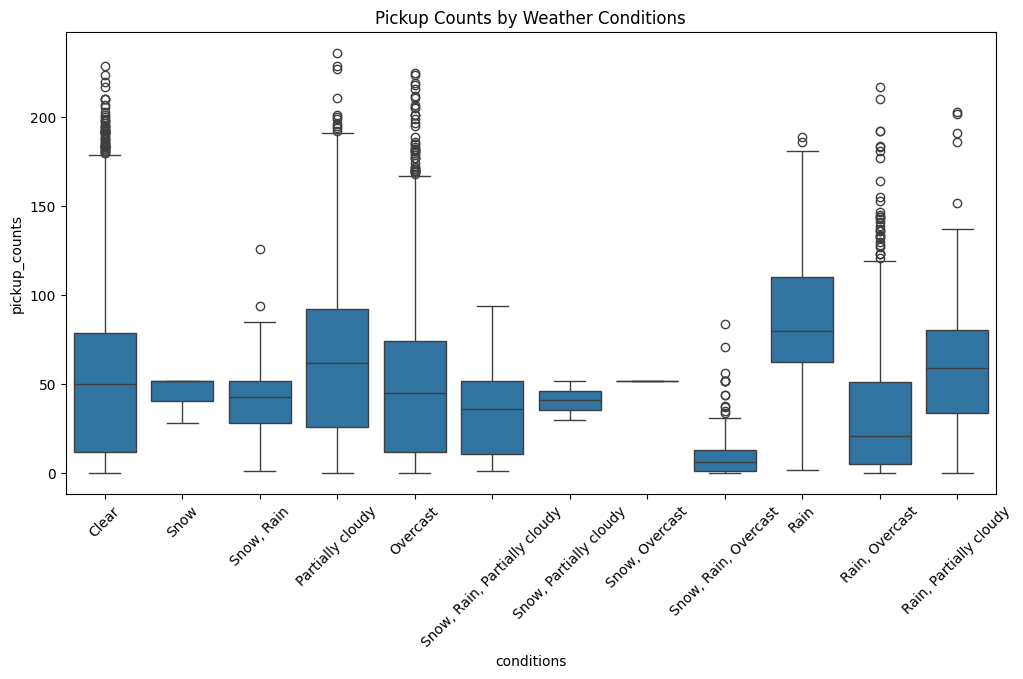

In [ ]:
import seaborn as sns

# Weather Condition Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='conditions', y='pickup_counts', data=w_pickups)
plt.title('Pickup Counts by Weather Conditions')
plt.xticks(rotation=45)
plt.show()

The plot illustrates how various weather conditions impact the frequency of pickups. When comparing to bad weather conditions like snow or rain, clear weather displays a greater range of pickup counts with a higher median. It's interesting to note that there are less pickups when there is rain and overcast conditions, as well as when there is snow and overcast conditions combined. This could mean that people are reluctant to travel in these situations. The number of pickups seems to be largely unaffected by partly cloudy weather, and a comparatively stable median indicates steady travel patterns. The correlation results are corroborated by this visual analysis, which indicates that weather plays a major role in transportation patterns, with clear skies being the most conducive to higher pickup counts.


Correlation Heatmap

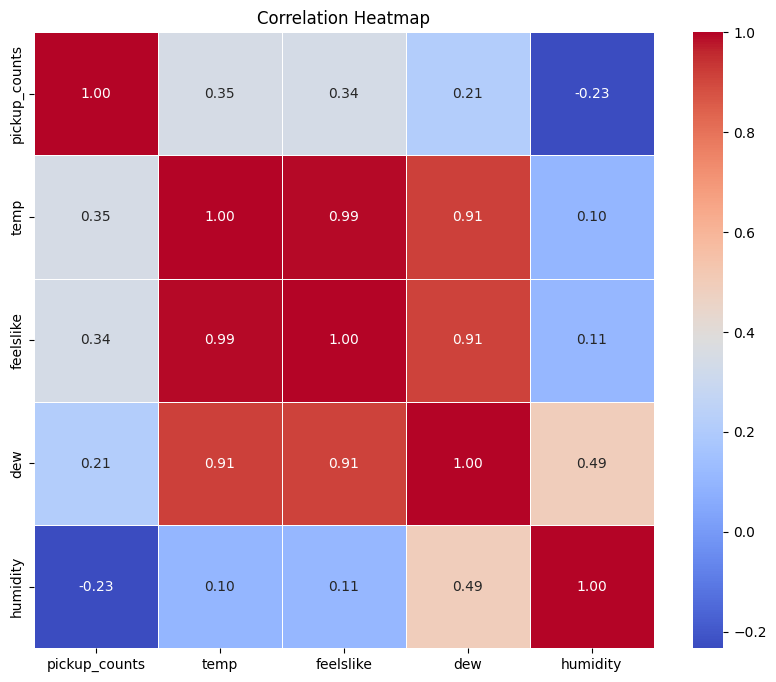

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation analysis
correlation_data = w_pickups[['pickup_counts', 'temp', 'feelslike', 'dew', 'humidity']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Warmer weather may result in more pickups, as shown by the correlation heatmap in our report, which shows that temperature and "feels like" are somewhat positively correlated with pickup counts. On the other hand, humidity has a minor detrimental effect on pickups, indicating that people might decide not to use transportation services when it's more humid. This graphic aid does a good job of summarizing the connections between weather conditions and transportation use

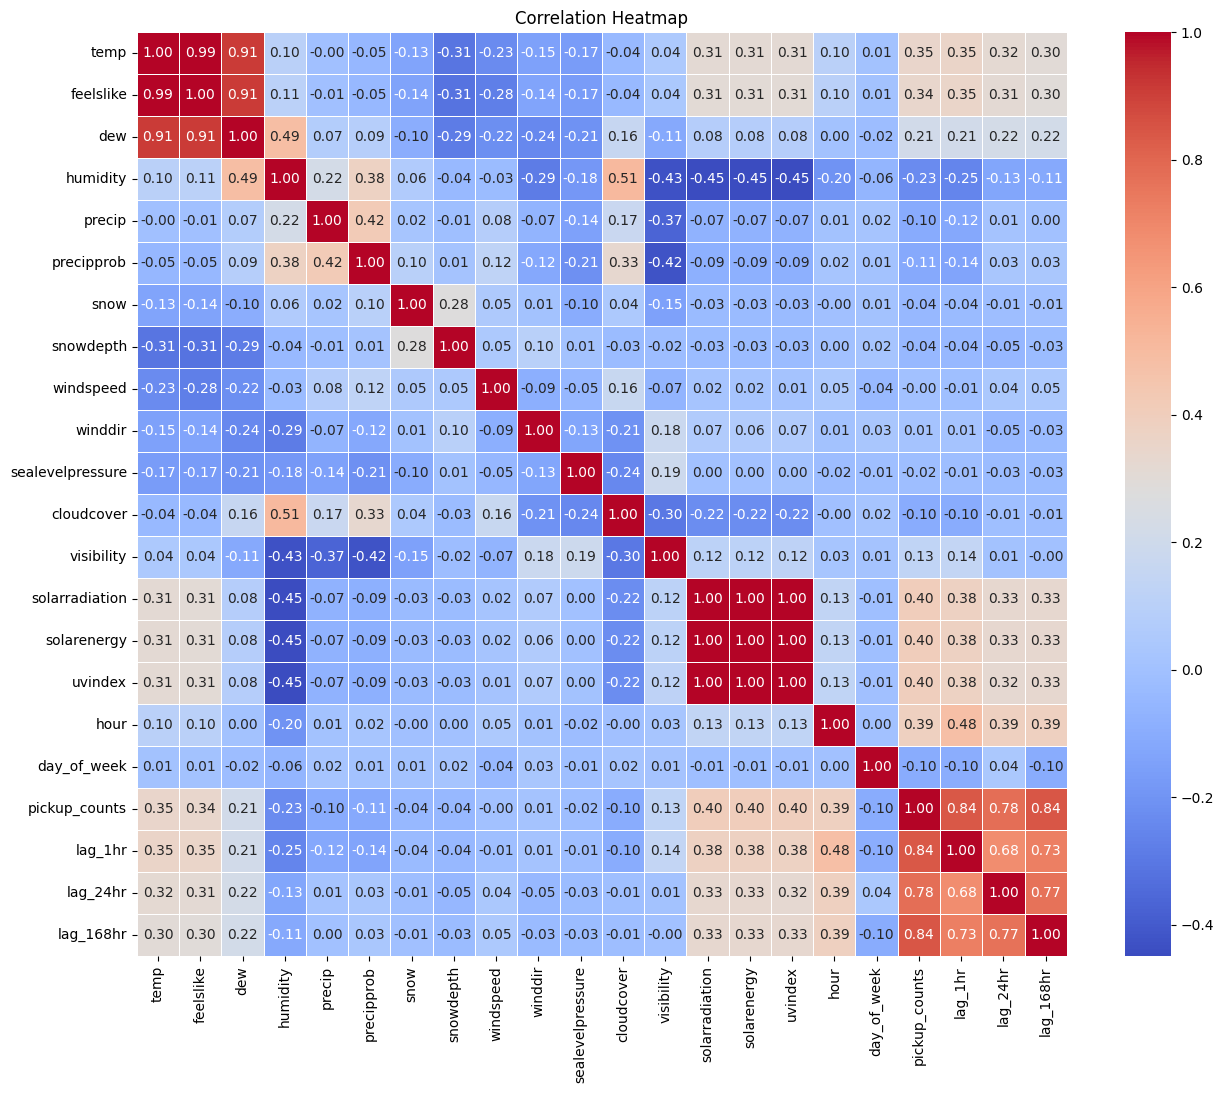

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation analysis
correlation_data = w_pickups.drop(['datetime', 'name', 'conditions', 'icon', 'stations', 'date'], axis=1)

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Models

Linear Regression Model 

Training R-squared: 0.8307534271344021
Test R-squared: 0.8446775484672364


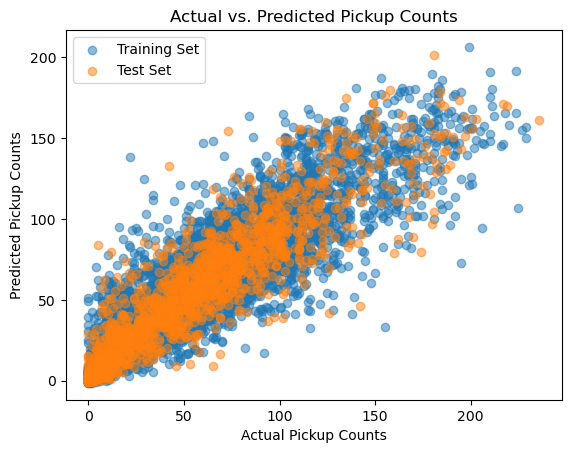

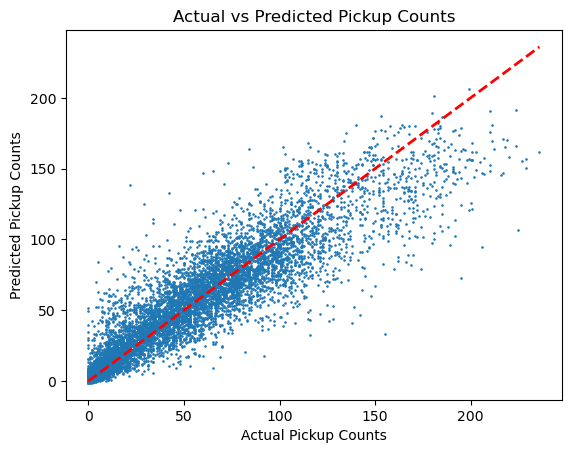

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Choose lag features to include
lag_features = ['lag_1hr', 'lag_24hr', 'lag_168hr']

# Select relevant columns for X (input features) and y (target variable)
X = w_pickups[['temp'] + lag_features]
y = w_pickups['pickup_counts']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but often improves model performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on both training and test sets
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
r_squared_train = r2_score(y_train, y_train_pred)
r_squared_test = r2_score(y_test, y_test_pred)
print(f'Training R-squared: {r_squared_train}')
print(f'Test R-squared: {r_squared_test}')

# Plotting 
plt.scatter(y_train, y_train_pred, label='Training Set', alpha=0.5)
plt.scatter(y_test, y_test_pred, label='Test Set', alpha=0.5)
plt.xlabel('Actual Pickup Counts')
plt.ylabel('Predicted Pickup Counts')
plt.title('Actual vs. Predicted Pickup Counts')
plt.legend()
plt.show()


# Combine training and testing sets for a comprehensive plot
y_combined = pd.concat([y_train, y_test])
y_pred_combined = pd.concat([pd.Series(y_train_pred), pd.Series(y_test_pred)])

# Scatter plot
plt.scatter(y_combined, y_pred_combined, s=0.75)
plt.ylabel("Predicted Pickup Counts")
plt.xlabel("Actual Pickup Counts")
plt.plot([min(y_combined), max(y_combined)], [min(y_combined), max(y_combined)], color="red", linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Pickup Counts")
plt.show()

A Random Forest 

Training R-squared: 0.9358097634423271
Test R-squared: 0.8752396354844346


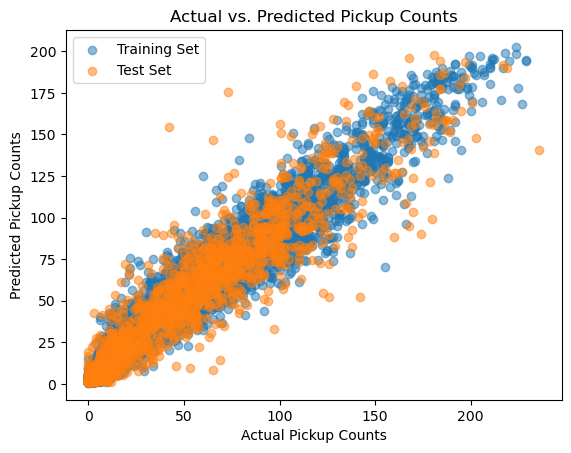

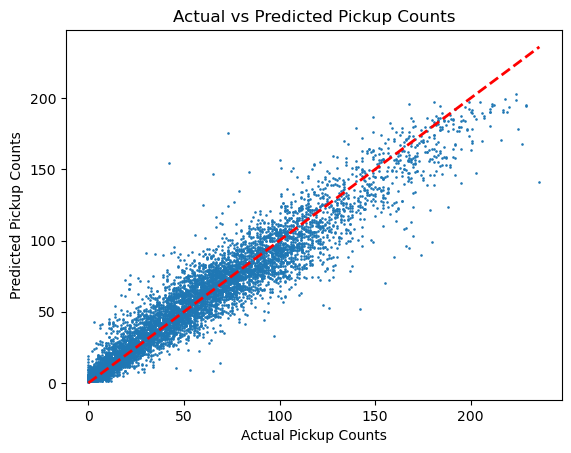

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Choose lag features to include
lag_features = ['lag_1hr', 'lag_24hr', 'lag_168hr']

# Select relevant columns for X (input features) and y (target variable)
X = w_pickups[['temp'] + lag_features]
y = w_pickups['pickup_counts']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but often improves model performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest model with adjusted hyperparameters
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on both the training and test sets
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
r_squared_train = r2_score(y_train, y_train_pred)
r_squared_test = r2_score(y_test, y_test_pred)

print(f'Training R-squared: {r_squared_train}')
print(f'Test R-squared: {r_squared_test}')


# Plotting 
plt.scatter(y_train, y_train_pred, label='Training Set', alpha=0.5)
plt.scatter(y_test, y_test_pred, label='Test Set', alpha=0.5)
plt.xlabel('Actual Pickup Counts')
plt.ylabel('Predicted Pickup Counts')
plt.title('Actual vs. Predicted Pickup Counts')
plt.legend()
plt.show()

# Combine training and testing sets for a comprehensive plot
y_combined = pd.concat([y_train, y_test])
y_pred_combined = pd.concat([pd.Series(y_train_pred), pd.Series(y_test_pred)])

# Scatter plot
plt.scatter(y_combined, y_pred_combined, s=0.75)
plt.ylabel("Predicted Pickup Counts")
plt.xlabel("Actual Pickup Counts")
plt.plot([min(y_combined), max(y_combined)], [min(y_combined), max(y_combined)], color="red", linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Pickup Counts")
plt.show()

Lasso 

Improved R-squared (Lasso): 0.8441800512777533


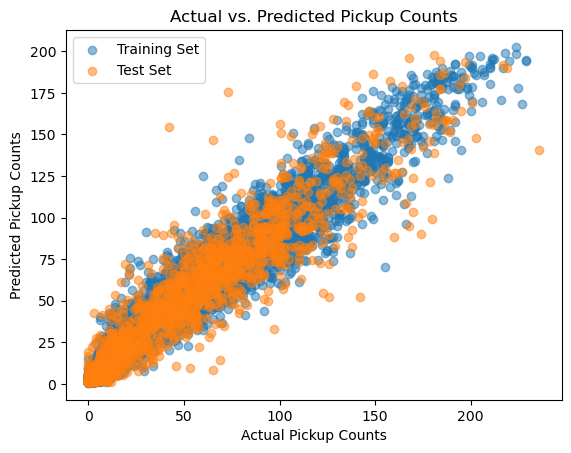

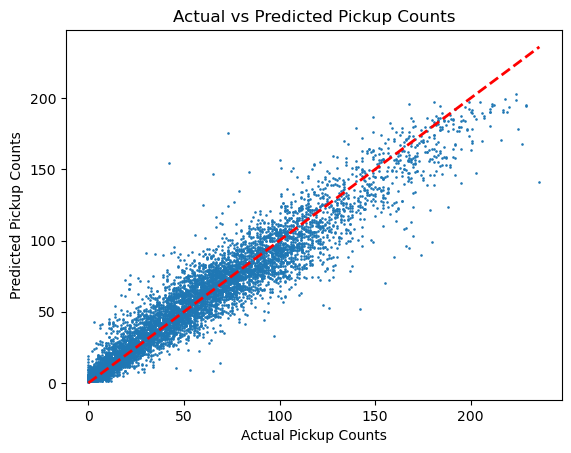

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Choose lag features to include
lag_features = ['lag_1hr', 'lag_24hr', 'lag_168hr']

# Add the temperature lag as a new feature
w_pickups['temp_lag'] = w_pickups['temp'].shift(1) 

# Select relevant columns for X (input features) and y (target variable)
X = w_pickups[lag_features]
y = w_pickups['pickup_counts']

# Drop rows with NaN values after creating the lag
X.dropna(inplace=True)
y = y[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but often improves model performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform hyperparameter tuning for Lasso regression
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso(random_state=42)
lasso_grid = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
lasso_grid.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_alpha = lasso_grid.best_params_['alpha']

# Create and train the Lasso model with the best hyperparameters
lasso_model = Lasso(alpha=best_alpha, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test_scaled)

# Evaluate the Lasso model
r_squared = r2_score(y_test, y_pred)
print(f'Improved R-squared (Lasso): {r_squared}')


# Plotting 
plt.scatter(y_train, y_train_pred, label='Training Set', alpha=0.5)
plt.scatter(y_test, y_test_pred, label='Test Set', alpha=0.5)
plt.xlabel('Actual Pickup Counts')
plt.ylabel('Predicted Pickup Counts')
plt.title('Actual vs. Predicted Pickup Counts')
plt.legend()
plt.show()


# Combine training and testing sets for a comprehensive plot
y_combined = pd.concat([y_train, y_test])
y_pred_combined = pd.concat([pd.Series(y_train_pred), pd.Series(y_test_pred)])

# Scatter plot
plt.scatter(y_combined, y_pred_combined, s=0.75)
plt.ylabel("Predicted Pickup Counts")
plt.xlabel("Actual Pickup Counts")
plt.plot([min(y_combined), max(y_combined)], [min(y_combined), max(y_combined)], color="red", linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Pickup Counts")
plt.show()

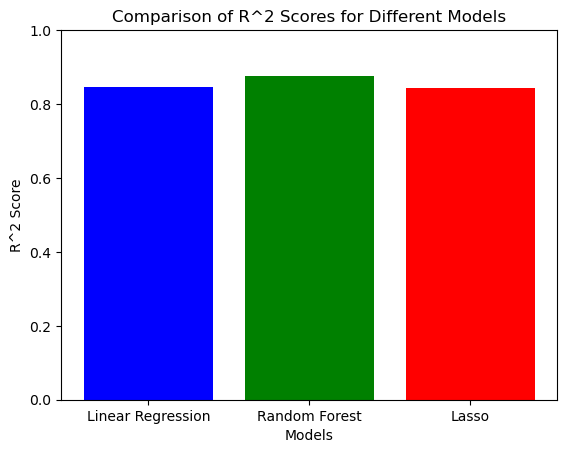

In [83]:
r2_linear = 0.8447686366851466  
r2_random_forest = 0.8751790524965884  
r2_lasso = 0.8441017463193482

models = ['Linear Regression', 'Random Forest', 'Lasso']
r2_values = [r2_linear, r2_random_forest, r2_lasso]
plt.bar(models, r2_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('R^2 Score')
plt.title('Comparison of R^2 Scores for Different Models')
plt.ylim(0, 1) 
plt.show()


It is advisable that adding more lagges or more seasonal variations they are likely to have a significant impact on demand patterns in order to further refine the model. A further exend would be long-term climate change models to create a more thorough and reliable picture of future CitiBike.

# Section 4: Conclusion